In [863]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [864]:
# --- 2. Define File Paths and Load Data ---

# Using constants for file paths makes the script easier to configure and read.
INPUT_FILE_PATH = '/Users/selim/Desktop/Projects/Python Projects/BI Data Cleaning Project/datas/raw/bi.csv'
OUTPUT_FILE_PATH = '/Users/selim/Desktop/Projects/Python Projects/BI Data Cleaning Project/datas/final/main_student_data.csv'

# Load the dataset, specifying 'latin-1' encoding to handle potential special characters.
df = pd.read_csv(INPUT_FILE_PATH, encoding='latin-1')

In [865]:
# --- 3. Standardize Column Names ---

# Define a clean and consistent list of column names and assign them to the DataFrame.
new_column_names = [
    'first_name', 'last_name', 'age', 'gender', 'country', 'residence',
    'entry_score', 'prior_education', 'study_hours', 'python_score', 'database_score'
]
df.columns = new_column_names

In [866]:
# --- 4. Clean and Standardize Data ---

# Clean the 'gender' column by standardizing values to 'F' and 'M'.
# This chain of operations first strips whitespace, then replaces variations.
df['gender'] = df['gender'].astype(str).str.strip().replace(['Female', 'female'], 'F').replace(['Male', 'male'], 'M')

# Clean the 'country' column by standardizing common names.
df['country'] = df['country'].astype(str).str.strip().replace(['Norge', 'norway'], 'Norway').replace('Rsa', 'RSA')

# Clean the 'residence' column by standardizing formatting.
df['residence'] = df['residence'].astype(str).str.strip().replace(['BI-Residence', 'BIResidence', 'BI_Residence'], 'BI Residence')

# Clean the 'prior_education' column by correcting typos and standardizing capitalization.
df['prior_education'] = df['prior_education'].astype(str).str.strip().replace(['DIPLOMA', 'diploma', 'Diplomaaa'], 'Diploma').replace('Barrrchelors', 'Bachelors').replace('HighSchool', 'High School')

# Impute missing 'python_score' values using the corresponding 'database_score'.
# This is a common strategy assuming a correlation between the two scores.
df.loc[df['python_score'].isna(), 'python_score'] = df['database_score']

# Clean and convert 'python_score' to a proper nullable integer type.
# 1. Convert to string to remove trailing '.0' from numbers.
# 2. Replace the text 'nan' with numpy's actual NaN object.
# 3. Convert the column to 'Int64' (a nullable integer) to support the NaN values.
df['python_score'] = df['python_score'].astype(str).str.strip().str.replace('.0', '', regex=False).replace('nan', np.nan).astype('Int64')

# Calculate the average score for each student.
df['average_score'] = (df['python_score'] + df['database_score']) / 2

# Perform a final, broad replacement of common null-value strings across the entire DataFrame.
df.replace(['nan', 'NaN', 'NULL', 'NA'], np.nan, inplace=True)

In [867]:
# --- 5. Verify and Save the Cleaned Data ---

# Optional but recommended: Display the DataFrame's info to check data types and null counts.
print("--- DataFrame Info After Cleaning ---")
df.info()
print(df.head())

# Save the cleaned DataFrame to a new CSV file.
# `index=False` prevents pandas from writing the DataFrame index as a column.
df.to_csv(OUTPUT_FILE_PATH, index=False)

print(f"\nCleaned data successfully saved to: {OUTPUT_FILE_PATH}")

--- DataFrame Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   first_name       77 non-null     object 
 1   last_name        77 non-null     object 
 2   age              77 non-null     int64  
 3   gender           77 non-null     object 
 4   country          77 non-null     object 
 5   residence        77 non-null     object 
 6   entry_score      77 non-null     int64  
 7   prior_education  77 non-null     object 
 8   study_hours      77 non-null     int64  
 9   python_score     77 non-null     Int64  
 10  database_score   77 non-null     int64  
 11  average_score    77 non-null     Float64
dtypes: Float64(1), Int64(1), int64(4), object(6)
memory usage: 7.5+ KB
  first_name  last_name  age gender       country  residence  entry_score  \
0  Christina     Binger   44      F        Norway    Private      

# 1. The Impact of Prior Education on User Success and Engagement

## Business Question: Do users with different prior educational backgrounds achieve different levels of success with our product, and how does this correlate with their engagement?


#### Required Columns: prior_education, python_score, database_score, study_hours.

In [868]:
# --- 1.1 Data Preparation for Analysis ---

# Create a dedicated DataFrame for this analysis, including only the relevant columns.
pe_on_success_engagement = df[['prior_education', 'python_score', 'database_score', 'study_hours','average_score']].copy()

# Define the logical order of educational levels from highest to lowest.
pe_order = ['Doctorate', 'Masters', 'Bachelors', 'Diploma', 'High School']

# Convert 'prior_education' to an ordered categorical type.
# This ensures that any sorting or plotting will follow this logical order.
pe_on_success_engagement['prior_education'] = pd.Categorical(pe_on_success_engagement['prior_education'], categories=pe_order, ordered=True)

In [869]:
# --- 1.2 Analysis of Success (Median Scores) by Prior Education ---

# Group by prior education and calculate the median score for both Python and Database exams.
# Median is a robust measure against outliers.
pe_on_success = pe_on_success_engagement.groupby('prior_education')[['python_score', 'database_score']].median()

/var/folders/3k/dwn327qx17928cqr783mk7qc0000gn/T/ipykernel_16997/3589838308.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pe_on_success = pe_on_success_engagement.groupby('prior_education')[['python_score', 'database_score']].median()


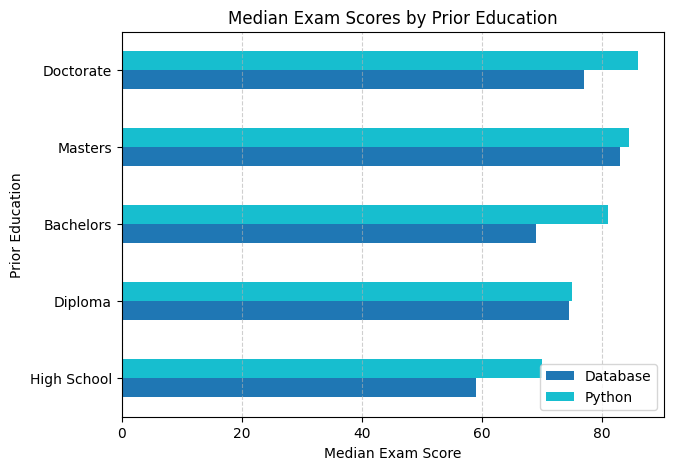

,python_score,database_score
prior_education,,
Doctorate,86.0,77.0
Masters,84.5,83.0
Bachelors,81.0,69.0
Diploma,75.0,74.5
High School,70.0,59.0


In [884]:
# --- Plot: Median Exam Scores by Prior Education ---
pe_on_success[['database_score', 'python_score']].iloc[::-1].plot(
    kind='barh',
    figsize=(7, 5),
    title='Median Exam Scores by Prior Education',
    xlabel='Median Exam Score',
    ylabel='Prior Education',
    colormap='tab10'
)
plt.legend(['Database', 'Python']) # Corrected legend order to match plot
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Display the resulting aggregated data.
pe_on_success

In [871]:
# --- 1.3 Analysis of Engagement (Study Hours vs. Score) ---

# Create a focused DataFrame for the engagement analysis.
success_engagement = pe_on_success_engagement[['prior_education', 'study_hours', 'average_score']]

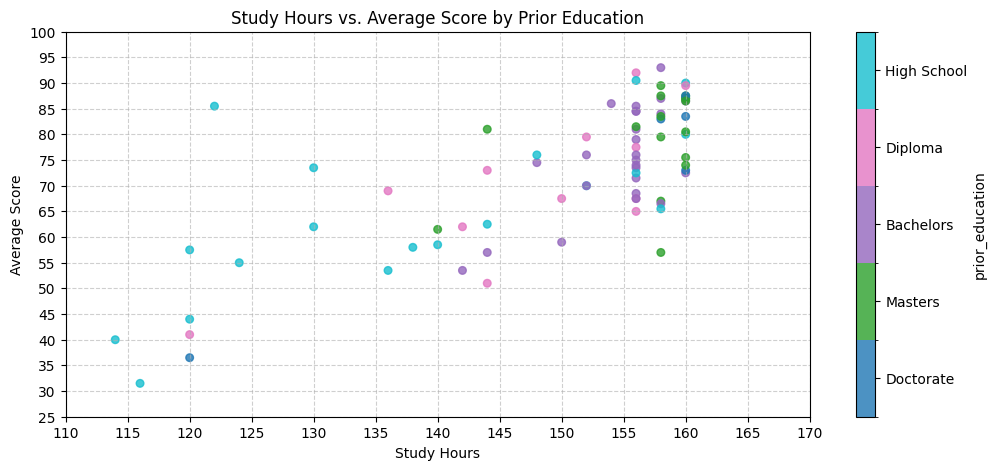

,prior_education,study_hours,average_score
0,Masters,158,57.0
1,Diploma,150,67.5
2,High School,130,62.0
3,High School,120,44.0
4,High School,122,85.5
...,...,...,...
72,Bachelors,150,59.0
73,Masters,158,83.5
74,Masters,158,87.5
75,Masters,160,80.5


In [872]:
# --- Plot: Correlation between Study Hours and Final Score ---
success_engagement.plot(
    kind='scatter',
    x='study_hours',
    y='average_score',
    c='prior_education', 
    colormap='tab10',  # A good colormap for distinct categories
    figsize=(12, 5),
    title='Study Hours vs. Average Score by Prior Education',
    xlabel='Study Hours',
    ylabel='Average Score',
    s=30, # Set the marker size
    alpha=0.8 # Add transparency to see overlapping points
)
plt.xticks(np.arange(110, 171, 5)) # Set x-axis ticks for better readability
plt.yticks(np.arange(25, 101, 5)) # Set y-axis ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Display the raw data used for the scatter plot.
success_engagement

# 2. Predictive Power of Entry Score on Final Performance


## Business Question: Can a user's initial entry_score predict their final performance in the Python and Database modules?



#### Required Columns: entry_score, python_score, database_score.


In [873]:
# --- 2.1 Data Preparation for Analysis ---

# Create a focused DataFrame with the necessary columns.
entry_performance_df = df[['entry_score', 'python_score', 'database_score','average_score']].copy()

In [874]:
# --- 2.2 Aggregate Scores by Entry Score ---

# To understand the general trend, we group by each unique 'entry_score'.
# Then, we calculate the median of all the 'average_final_score' values within that group.
# Using the median provides a robust measure that is less sensitive to outlier student performances.
final_performance_by_entry = entry_performance_df.groupby('entry_score')[['average_score']].median()

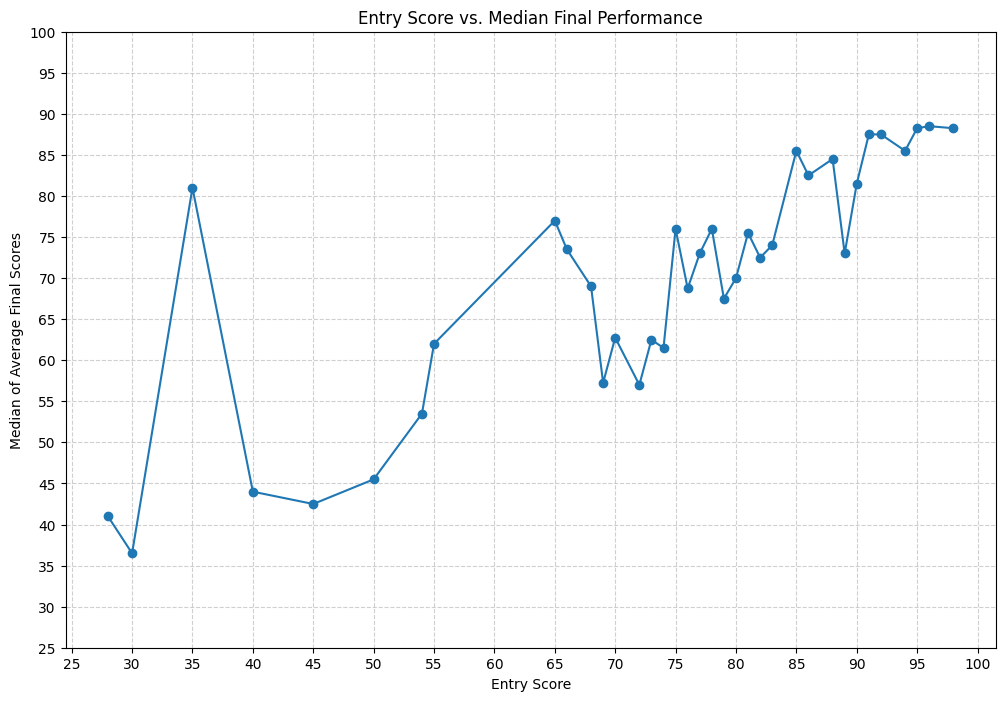

In [888]:
# --- 2.3 Visualize the Relationship ---

# Plot the median final score against the entry score to visually inspect for a correlation or trend.
final_performance_by_entry['average_score'].plot(
    kind='line',
    figsize=(12, 8), # Adjusted size for a better aspect ratio
    legend=False,
    title='Entry Score vs. Median Final Performance',
    xlabel='Entry Score',
    ylabel='Median of Average Final Scores', # More descriptive label
    marker='o',
)
# Set custom ticks for both axes to ensure a clear and consistent scale.
plt.xticks(np.arange(25, 101, 5))
plt.yticks(np.arange(25, 101, 5))
plt.grid(True, linestyle='--', alpha=0.6) # Use a full grid for easier value tracking
plt.show()

# 3. The Relationship Between Time Spent and User Performance


## Business Question: How does the number of study hours a user invests correlate with their performance? Is there a point of diminishing returns?


#### Required Columns: study_hours, python_score, database_score.


In [876]:
# --- 3.1 Data Preparation ---

# Create a focused DataFrame for this analysis.
time_performance = df[['study_hours', 'python_score', 'database_score', 'average_score']].copy()

In [877]:
# --- 3.2 Aggregate Performance by Study Hours ---

# Group by each unique value of 'study_hours' to see the typical performance.
# We calculate the median score for both subjects for everyone who studied that exact number of hours.
# .sort_index() ensures the data is ordered chronologically by study hours for the line plot.
time_performance_agg = time_performance.groupby('study_hours')[['python_score', 'database_score', 'average_score']].median().sort_index()

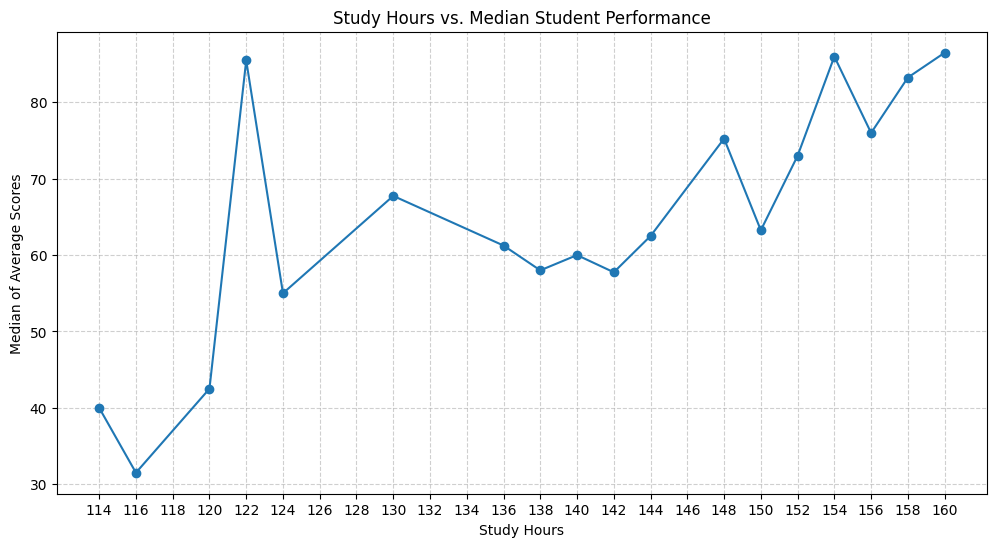

In [878]:
# --- 3.3 Visualize the Correlation ---

# Plot the calculated median average score against the number of study hours.
# A line plot is effective here to show the trend as study hours increase.
time_performance_agg['average_score'].plot(
    kind='line',
    figsize=(12, 6), # Adjusted for a better aspect ratio
    legend=False,
    title='Study Hours vs. Median Student Performance',
    xlabel='Study Hours',
    ylabel='Median of Average Scores', # Accurately describes the metric
    marker='o',
)
plt.xticks(np.arange(114, 161, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [879]:
# --- Display the resulting aggregated data for review ---
time_performance_agg

,python_score,database_score,average_score
study_hours,,,
114,30.0,50.0,40.0
116,33.0,30.0,31.5
120,37.5,55.5,42.5
122,91.0,80.0,85.5
124,48.0,62.0,55.0
130,81.0,54.5,67.75
136,58.5,64.0,61.25
138,69.0,47.0,58.0
140,62.0,58.0,60.0


# 4. Geographic and Demographic Performance Analysis



## Business Question: Are there significant differences in performance based on a user's country or age?


#### Required Columns: country, age, python_score, database_score.


In [880]:
# --- 4.1 Data Preparation ---

# Create a base DataFrame for both analyses.
geo_demo_analysis = df[['country', 'age', 'python_score', 'database_score', 'average_score']].copy()

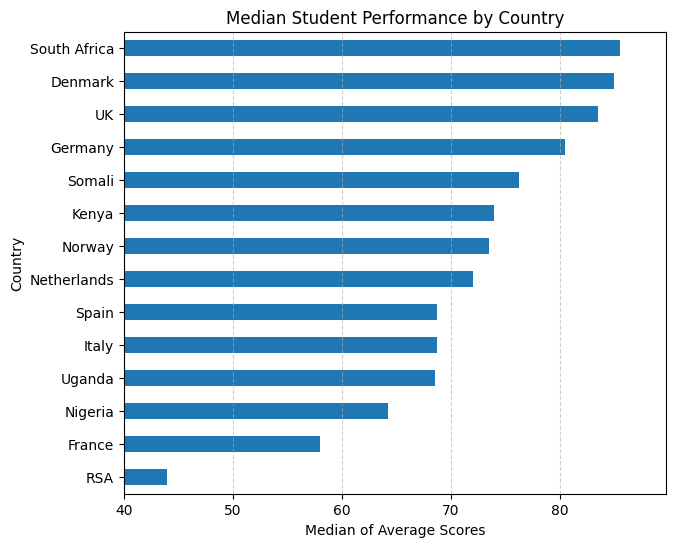

,python_score,database_score,average_score
country,,,
South Africa,91.0,80.0,85.5
Denmark,83.5,86.5,85.0
UK,85.0,82.0,83.5
Germany,87.0,74.0,80.5
Somali,78.0,74.5,76.25
Kenya,81.0,68.0,74.0
Norway,81.0,73.0,73.5
Netherlands,79.5,64.5,72.0
Italy,69.0,68.5,68.75


In [ ]:
# --- 4.2 Geographic Analysis by Country ---

# Group by country and calculate the median of the scores to find the typical performance.
# We sort by the median 'average_score' to rank the countries.
geo_analysis = geo_demo_analysis.groupby('country')[['python_score', 'database_score', 'average_score']].median().sort_values('average_score', ascending=False)

# --- Plot: Median Performance by Country ---
# Sorting by ascending=True for a barh plot places the highest value at the top.
geo_analysis['average_score'].sort_values(ascending=True).plot(
    kind='barh',
    figsize=(7, 6), # Adjusted for better spacing
    legend=False,
    title='Median Student Performance by Country',
    xlabel='Median of Average Scores',
    ylabel='Country',
)
# Set the lower x-axis limit to 40 to focus the view on the variation between top countries.
plt.xlim(left=40)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Display the resulting country data for review.
geo_analysis

In [882]:
# --- 4.3 Demographic Analysis by Age ---

# Group by age and calculate the median of the scores.
# .sort_index() ensures the data is ordered chronologically by age for the line plot.
demo_analysis = geo_demo_analysis.groupby('age')[['python_score', 'database_score', 'average_score']].median().sort_index()

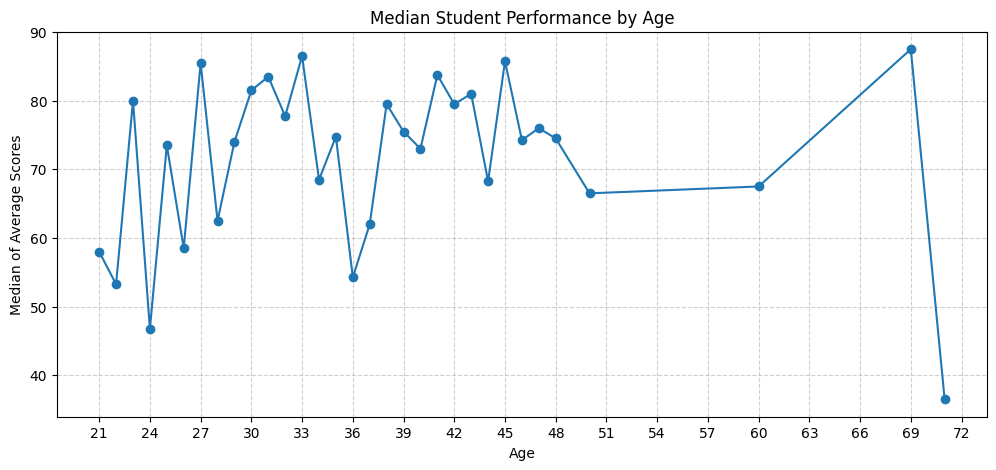

In [883]:
# --- Plot: Median Performance by Age ---
demo_analysis['average_score'].plot(
    kind='line',
    figsize=(12, 5),
    legend=False,
    title='Median Student Performance by Age',
    xlabel='Age',
    ylabel='Median of Average Scores',
    marker='o'
)
plt.xticks(np.arange(21, 73, 3)) # Adjusted range to be inclusive
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()